## Машинное обучение в бизнесе

## Задание

Построить модель градиентного бустинга для многоклассовой классификации для показателя RiskVar на 1 и 2 частях набора данных freMPL. Необходимо предобработать исходные данные (данные содержат ряд других категориальных признаков, не рассматривавшихся на занятиях). Оценить результаты построенного классификатора, выявить возможные проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем. Можно использовать различные методы для подбора гиперпараметров

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
import itertools

## Обзор датасета <left><a class="anchor" id="gen"></a><left>

In [20]:
# Загрузим набор данных

df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     40732 non-null  float64
 1   LicAge       40732 non-null  int64  
 2   RecordBeg    40732 non-null  object 
 3   RecordEnd    21616 non-null  object 
 4   VehAge       40732 non-null  object 
 5   Gender       40732 non-null  object 
 6   MariStat     40732 non-null  object 
 7   SocioCateg   40732 non-null  object 
 8   VehUsage     40732 non-null  object 
 9   DrivAge      40732 non-null  int64  
 10  HasKmLimit   40732 non-null  int64  
 11  BonusMalus   40732 non-null  int64  
 12  VehBody      40732 non-null  object 
 13  VehPrice     40732 non-null  object 
 14  VehEngine    40732 non-null  object 
 15  VehEnergy    40732 non-null  object 
 16  VehMaxSpeed  40732 non-null  object 
 17  VehClass     40732 non-null  object 
 18  ClaimAmount  40732 non-null  float64
 19  Risk

В датасете есть переменная "ClaimAmount", с отрицательными значениями. Заметим, что для этой переменной целевое значение "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [21]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
231,-200.867674,0
404,-381.646224,0
568,-289.837160,0
794,-528.762236,0
822,-27.029003,0


In [22]:
# Обнуление отрицательных значений

df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [23]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [24]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP9,10
CSP7,55
CSP3,837
CSP2,1476
CSP1,1975
CSP4,3279
CSP6,4885
CSP5,28215


In [25]:
# one hot encoding преобразование для категорий VehUsage и SocioCateg
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [26]:
df = df.select_dtypes(exclude=['object'])

In [27]:
# Производные признаки

def get_deriv_feats(df, colname):
    df[colname + ' (^2)'] = df[colname] ** 2
    df[colname + ' (^3)'] = df[colname] ** 3
    df[colname + ' (sqrt)'] = np.sqrt(df[colname])
    df[colname + ' (log)'] = np.log(df[colname])
    df[colname + ' (/ 2)'] = df[colname] / 2
    df[colname + ' (/ 4)'] = df[colname] / 4
    return df

df = get_deriv_feats(df, 'Exposure')

# Первая производная
first_diff = np.array(df.iloc[1:,2].values - df.iloc[:-1,2].values).astype('float32') 
df['DrivAge_diff1'] = 0
df['DrivAge_diff1'] =  df['DrivAge_diff1'].astype('float') 
df['DrivAge_diff1'].values[1:] = first_diff

#  Переменная, квадрат возраста.
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

In [28]:
df.columns

Index(['Exposure', 'LicAge', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'RiskVar', 'ClaimInd', 'VehUsage_Private',
       'VehUsage_Private+trip to office', 'VehUsage_Professional',
       'VehUsage_Professional run', 'SocioCateg_CSP1', 'SocioCateg_CSP2',
       'SocioCateg_CSP3', 'SocioCateg_CSP4', 'SocioCateg_CSP5',
       'SocioCateg_CSP6', 'SocioCateg_CSP7', 'SocioCateg_CSP9',
       'Exposure (^2)', 'Exposure (^3)', 'Exposure (sqrt)', 'Exposure (log)',
       'Exposure (/ 2)', 'Exposure (/ 4)', 'DrivAge_diff1', 'DrivAgeSq'],
      dtype='object')

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [31]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [32]:
df.RiskVar -= 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [33]:
FreqCount = pd.DataFrame(df.RiskVar.value_counts()).rename({'RiskVar': 'Count'}, axis=1)
mx = FreqCount.Count.max()
FreqCount['Freq'] = FreqCount.Count / mx

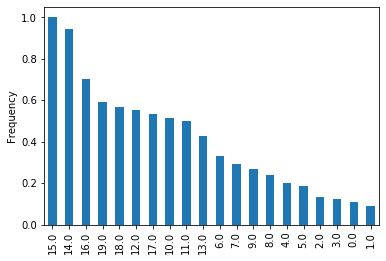

In [34]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [35]:
FreqCount

,Count,Freq
15.0,4906,1.000000
14.0,4625,0.942723
16.0,3444,0.701998
19.0,2894,0.589890
18.0,2773,0.565226
12.0,2719,0.554219
17.0,2614,0.532817
10.0,2533,0.516307
11.0,2445,0.498369
13.0,2096,0.427232


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [39]:
df['weight'] = 1
df.loc[df.RiskVar.isin([14, 15]), 'weight'] = 0.6
df.head()

,Exposure,LicAge,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,...,SocioCateg_CSP9,Exposure (^2),Exposure (^3),Exposure (sqrt),Exposure (log),Exposure (/ 2),Exposure (/ 4),DrivAge_diff1,DrivAgeSq,weight
0,0.583,366,55,0,72,0.000000,14.0,0,0,0,...,0,0.339889,0.198155,0.763544,-0.539568,0.2915,0.14575,0.0,3025,0.6
1,0.200,187,34,0,80,0.000000,19.0,0,0,1,...,0,0.040000,0.008000,0.447214,-1.609438,0.1000,0.05000,-21.0,1156,1.0
2,0.083,169,33,0,63,0.000000,16.0,0,0,0,...,0,0.006889,0.000572,0.288097,-2.488915,0.0415,0.02075,-1.0,1089,1.0
3,0.375,170,34,0,63,0.000000,16.0,0,0,0,...,0,0.140625,0.052734,0.612372,-0.980829,0.1875,0.09375,1.0,1156,1.0
4,0.500,224,53,0,72,1418.610272,18.0,1,0,0,...,0,0.250000,0.125000,0.707107,-0.693147,0.2500,0.12500,19.0,2809,1.0


## Train test split <left><a class="anchor" id="gen"></a><left>

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar'], axis=1), df.RiskVar, test_size=0.3)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [41]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), y_valid)
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), y_test)

Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [42]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'num_class': 20,
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda']
    }
    
    cv_result = xgb.cv(parameters, xgb_train, 
                       num_boost_round=int(params['num_boost_round']), 
                       nfold=3, seed=0, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0]
    return score

In [ ]:
space = {'num_boost_round': hp.choice('num_boost_round', [50, 100]),
         'max_depth': hp.choice('max_depth', [5, 10, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 1),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1)
        }
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

  6%|██▉                                              | 3/50 [03:08<45:18, 57.83s/trial, best loss: 0.8583069999999999]

Далее обучим нашу модель с оптимальными параметрами

In [ ]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 20
best_params

In [ ]:
xgb_risk = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')),
                     params=best_params, dtrain=xgb_train,
                     evals=[(xgb_train, "train"),(xgb_valid, "valid")],
                     maximize=False, early_stopping_rounds=10, verbose_eval=True)

In [ ]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]

for dfset in dfsets:
    class_preds = xgb_risk.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

In [ ]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()